# Headers

In [1]:
# imports

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import os
import itertools
from pdb import set_trace
from datetime import datetime

#plt.style.use('seaborn-pastel')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
#plt.style.use('ggplot')
#plt.style.use('seaborn')
#plt.style.use('seaborn-paper')

plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15
plt.rcParams['font.size']=17

%matplotlib inline

In [2]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [3]:
def avg_std(*vals):
    avg = []
    std = []
    #for val in zip(*vals):
    for val in itertools.zip_longest(*vals):
        avg.append(np.mean([v for v in val if v is not None]))
        std.append(np.std([v for v in val if v is not None]))
    avg = np.array(avg)
    std = np.array(std)
    return avg,std

In [4]:
def avg_std_balanced(vals,steps):
    avg,std,stp = [],[],[]
    min_len = min([len(val) for val in vals])
    max_stp = max([max(step) for step in steps])
    for i in range(0,min_len):
        avg.append(np.mean())

# Histograms

In [ ]:
df = pd.read_csv("../experiments/experiments.csv",index_col=0)

In [ ]:
plt.figure(figsize=(6,4))
plt.xlabel("hours",fontsize=20)
plt.ylabel("#",fontsize=20)
plot = df[df.perf == False].hours.hist(bins=30)
plt.savefig("plots/hist_hours.pdf",bbox_inches="tight", pad_inches=0)

In [ ]:
# number of experiments over 10 hours
1 - df[df.hours < 10].hours.count()/df[pd.isna(df.hours) == False].hours.count()

In [ ]:
df.hours.describe()

In [ ]:
# Total number of hours (in days)
df.hours.sum()/24

In [ ]:
plt.figure(figsize=(6,4))
plt.xlabel("# of episodes",fontsize=20)
plt.ylabel("#",fontsize=20)
df[df.perf == False].n_ep.hist(bins=25)
plt.savefig("plots/hist_n_ep.pdf",bbox_inches="tight", pad_inches=0)

# Memory plots

In [ ]:
import mprof

In [ ]:
dict_solved = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729151034.dat")
dict_bad    = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729150843.dat")

t_solved = [elem - dict_solved['timestamp'][0] for elem in dict_solved['timestamp']]
t_bad    = [elem - dict_bad['timestamp'][0]    for elem in dict_bad['timestamp']]

In [ ]:
print(dict.keys())

In [ ]:
plt.plot(t_solved,dict_solved['mem_usage'],label="v0.12.6")
plt.plot(t_bad   ,dict_bad['mem_usage'],   label="v0.12.5")
plt.ylabel("Memory used (in MiB)")
plt.xlabel("time (in seconds)")
plt.legend(loc=[1.1,0])
plt.title("Memory footprint\n")
plt.savefig("plots/mem_profiler.pdf",bbox_inches="tight", pad_inches=0)

# Histogram of actions

In [ ]:
loader = EventFileLoader("/hdd/Documents/HRL/experiments/198_Nav_new/logs/extra/events.out.tfevents.1563829770.743d94694d36")

wtimes,steps,actions = [],[],[]
for event in loader.Load():
    #set_trace()
    wtime   = event.wall_time
    step    = event.step
    if len(event.summary.value) > 0:
        summary = event.summary.value[0]
        if summary.tag == 'episode/actions':
            wtimes += [wtime]*int(summary.histo.num)
            steps  += [step] *int(summary.histo.num)

            for num,val in zip(summary.histo.bucket,summary.histo.bucket_limit):
                actions += [val] *int(num)

In [ ]:
actions = [int(round(a,0)) for a in actions]

In [ ]:
len(actions)

In [ ]:
set(actions)

In [ ]:
plt.ylabel("#",fontsize=20)
plt.xlabel("Discrete actions",fontsize=20)
plt.title("Histogram of discrete actions\n",fontsize=20)
plt.hist(actions[-2000:])
plt.savefig("plots/hist_actions.pdf",bbox_inches="tight", pad_inches=0)

In [ ]:
plt.hist(actions[:1000],density=1)

# Turn H vs N2N

### n2n

In [5]:
w_times_a, step_nums_a, vals_a = pickle.load(open('./Turn_n2n_vs_h/n2n_a.pkl','rb'))
w_times_b, step_nums_b, vals_b = pickle.load(open('./Turn_n2n_vs_h/n2n_b.pkl','rb'))
w_times_c, step_nums_c, vals_c = pickle.load(open('./Turn_n2n_vs_h/n2n_c.pkl','rb'))
w_times_d, step_nums_d, vals_d = pickle.load(open('./Turn_n2n_vs_h/n2n_d.pkl','rb'))
w_times_e, step_nums_e, vals_e = pickle.load(open('./Turn_n2n_vs_h/n2n_e.pkl','rb'))

vals_a_smooth = smooth(vals_a, 0.99)
vals_b_smooth = smooth(vals_b, 0.99)
vals_c_smooth = smooth(vals_c, 0.99)
vals_d_smooth = smooth(vals_d, 0.99)
vals_e_smooth = smooth(vals_e, 0.99)

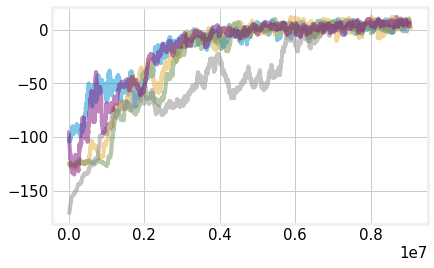

In [91]:
plt.plot(step_nums_a, vals_a_smooth,alpha=0.5)
plt.plot(step_nums_b, vals_b_smooth,alpha=0.5)
plt.plot(step_nums_c, vals_c_smooth,alpha=0.5)
plt.plot(step_nums_d, vals_d_smooth,alpha=0.5)
plt.plot(step_nums_e, vals_e_smooth,alpha=0.5)

In [7]:
print("min max step",min([max(step) for step in [step_nums_a,step_nums_b,step_nums_c,step_nums_d,step_nums_e]]))
print("max step",max([max(step) for step in [step_nums_a,step_nums_b,step_nums_c,step_nums_d,step_nums_e]]))

min max step 9000609
max step 9058865


#### times to max

In [134]:
def plt_max(steps,vals,walltime = None):
    if walltime is not None:
        print("time to val", (walltime[[idx for idx,val in enumerate(vals) if val >0][0]]-walltime[0])/3600)
    plt.plot(steps, vals)
    plt.plot(steps[[idx for idx,val in enumerate(vals) if val >0][0]],vals[[idx for idx,val in enumerate(vals) if val >0][0]],'.',alpha=1)


time to val 9.361574464440345


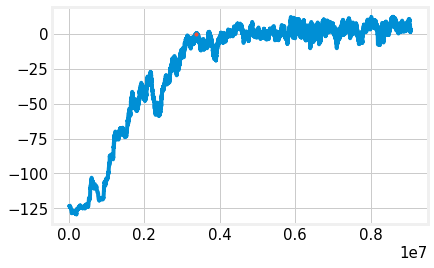

In [137]:
plt_max(step_nums_b,vals_b_smooth,w_times_b)

time to val 139.1734584971269


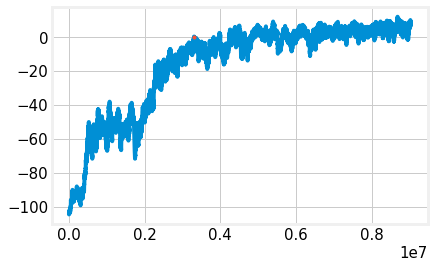

In [138]:
plt_max(step_nums_a,vals_a_smooth,w_times_a)

time to val 14.971363103522195


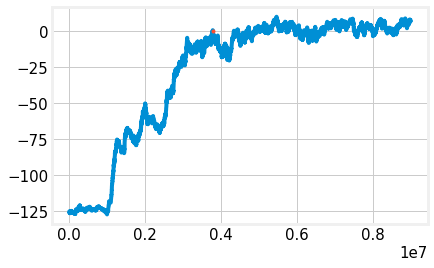

In [139]:
plt_max(step_nums_c,vals_c_smooth,w_times_c)

time to val 24.489542881382835


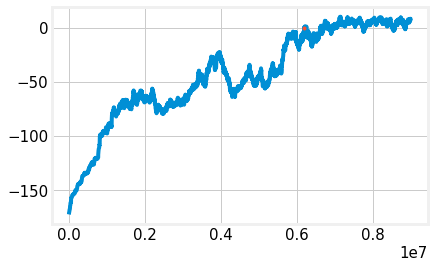

In [140]:
plt_max(step_nums_d,vals_d_smooth,w_times_d)

time to val 77.65863418552611


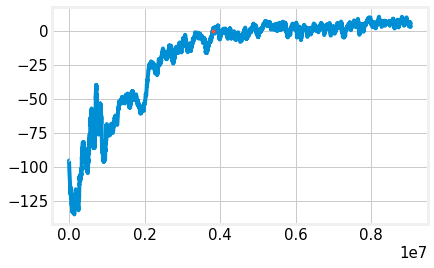

In [141]:
plt_max(step_nums_e,vals_e_smooth,w_times_e)

In [122]:
# un realible walltime
print("a) hours to reach max",(w_times_a[[idx for idx,val in enumerate(vals_a_smooth) if val >0][0]]-w_times_a[0])/3600)
print("b) hours to reach max",(w_times_b[[idx for idx,val in enumerate(vals_b_smooth) if val >0][0]]-w_times_b[0])/3600)
print("c) hours to reach max",(w_times_c[[idx for idx,val in enumerate(vals_c_smooth) if val >0][0]]-w_times_c[0])/3600)
print("d) hours to reach max",(w_times_d[[idx for idx,val in enumerate(vals_d_smooth) if val >0][0]]-w_times_d[0])/3600)
print("a) hours to reach max",(w_times_e[[idx for idx,val in enumerate(vals_e_smooth) if val >0][0]]-w_times_e[0])/3600)


a) hours to reach max 139.1734584971269
b) hours to reach max 9.361574464440345
c) hours to reach max 14.971363103522195
d) hours to reach max 24.489542881382835
a) hours to reach max 77.65863418552611


#### plots

In [8]:
w_times_a = [wt - w_times_a[0] for wt in w_times_a]
w_times_b = [wt - w_times_b[0] for wt in w_times_b]
w_times_c = [wt - w_times_c[0] for wt in w_times_c]
w_times_d = [wt - w_times_d[0] for wt in w_times_d]
w_times_e = [wt - w_times_e[0] for wt in w_times_e]

df = pd.DataFrame(data={
    'walltime':w_times_a+w_times_b+w_times_c+w_times_d+w_times_e,
    'discounted_rewards':vals_a_smooth+vals_b_smooth+vals_c_smooth+vals_d_smooth+vals_e_smooth
    },index=step_nums_a+step_nums_b+step_nums_c+step_nums_d+step_nums_e)

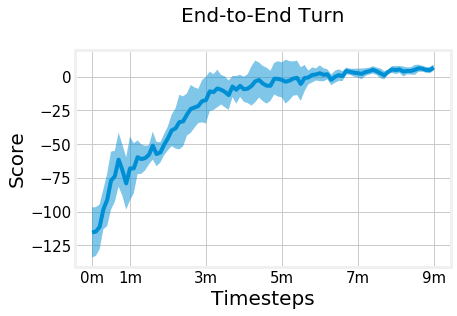

In [9]:
n2n_avg = df.groupby((df.index//100000)*100000).mean().discounted_rewards
n2n_wt  = df.groupby((df.index//100000)*100000).mean().walltime
n2n_std = df.groupby((df.index//100000)*100000).std().discounted_rewards
n2n_stp = n2n_avg.index

plt.plot(n2n_stp,n2n_avg)
plt.fill_between(n2n_stp,n2n_avg-n2n_std,n2n_avg+n2n_std,alpha=.5)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e6,3e6,5e6,7e6,9e6],["0m","1m","3m","5m","7m","9m"])
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

### H

In [ ]:
w_times_h_a, step_nums_h_a, vals_h_a = pickle.load(open('./Turn_n2n_vs_h/h_a.pkl','rb'))
w_times_h_b, step_nums_h_b, vals_h_b = pickle.load(open('./Turn_n2n_vs_h/h_b.pkl','rb'))
vals_h_a_smooth = smooth(vals_h_a, 0.99)
vals_h_b_smooth = smooth(vals_h_b, 0.99)

In [56]:
h_c_event = EventAccumulator('../experiments/241_Turn_v1_H_control/logs/PPO2_1/')
h_c_event.Reload()

In [70]:
h_c = list(zip(*h_c_event.Scalars("episode/episode_reward")))
h_c[2] = smooth(h_c[2],.99)

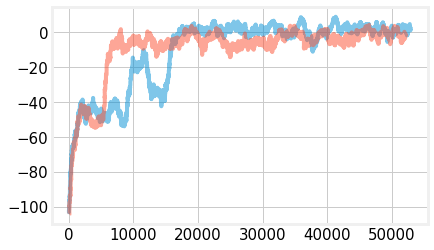

In [63]:
plt.plot(step_nums_h_a, vals_h_a_smooth,alpha=0.5)
plt.plot(step_nums_h_b, vals_h_b_smooth,alpha=0.5)

In [11]:
w_times_h_a = [wt - w_times_h_a[0] for wt in w_times_h_a]
w_times_h_b = [wt - w_times_h_b[0] for wt in w_times_h_b]

df_h = pd.DataFrame(data={
    'walltime':w_times_h_a+w_times_h_b,
    'discounted_rewards':vals_h_a+vals_h_b,
    },index=step_nums_h_a+step_nums_h_b)

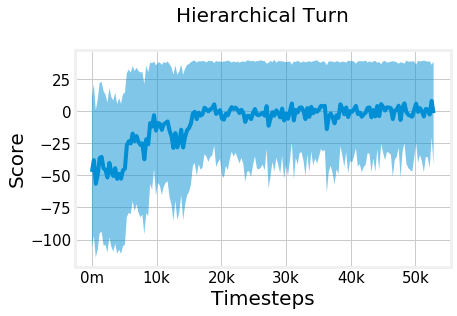

In [14]:
h_avg = df_h.groupby((df_h.index//300)*300).mean().discounted_rewards
h_wt  = df_h.groupby((df_h.index//300)*300).mean().walltime
h_std = df_h.groupby((df_h.index//300)*300).std().discounted_rewards
h_stp = h_avg.index

plt.plot(h_stp,h_avg)
plt.fill_between(h_stp,h_avg-h_std,h_avg+h_std,alpha=.5)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Hierarchical Turn\n",fontsize=20)
plt.xticks([0,1e4,2e4,3e4,4e4,5e4],["0m","10k","20k","30k","40k","50k"])
plt.savefig("plots/h-turn.pdf",bbox_inches="tight", pad_inches=0)

In [15]:
tleft = EventAccumulator('../experiments/84_Turn_left_v2/logs/PPO2_1')
tleft.Reload()
tright = EventAccumulator('../experiments/85_Turn_right_v2/logs/PPO2_1')
tright.Reload()

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


In [16]:
tleft_vals = list(zip(*tleft.Scalars("episode/episode_reward")))
tright_vals = list(zip(*tright.Scalars("episode/episode_reward")))

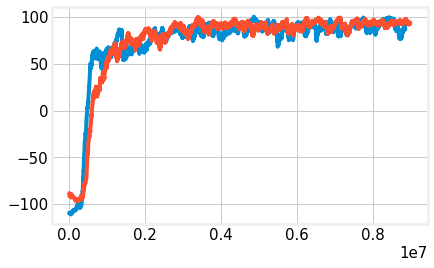

In [17]:
plt.plot(tleft_vals[1],smooth(tleft_vals[2],.99))
plt.plot(tright_vals[1],smooth(tright_vals[2],.99))

In [31]:
print("steps to reach max in Turn_left", tleft_vals[1][tleft_vals[2].index(max(tleft_vals[2]))])
print("steps to reach max in Turn_right",tright_vals[1][tright_vals[2].index(max(tright_vals[2]))])
print("steps to reach max in Turn", h_avg.idxmax())
print("total steps to reach max", tleft_vals[1][tleft_vals[2].index(max(tleft_vals[2]))]+tright_vals[1][tright_vals[2].index(max(tright_vals[2]))]+h_avg.idxmax())

steps to reach max in Turn_left 5841777
steps to reach max in Turn_right 1929179
steps to reach max in Turn 52500
total steps to reach max 7823456


In [32]:
print("step when reached the max value for n2n model", n2n_avg.idxmax())

step when reached the max value for n2n model 9000000


---

In [33]:
(max(tleft_vals[0])-tleft_vals[0][0])/60/60

58.943258586724596

In [34]:
print("steps to reach max in Turn_left", (tleft_vals[0][tleft_vals[2].index(max(tleft_vals[2]))]-tleft_vals[0][0])/60/60)
print("steps to reach max in Turn_right",(tright_vals[0][tright_vals[2].index(max(tright_vals[2]))]-tright_vals[0][0])/60/60)
print("walltime to reach max in H",(h_wt.loc[h_avg.idxmax()])/3600)
print("walltime to reach max in total H",(h_wt.loc[h_avg.idxmax()]+tleft_vals[0][tleft_vals[2].index(max(tleft_vals[2]))]-tleft_vals[0][0]+tright_vals[0][tright_vals[2].index(max(tright_vals[2]))]-tright_vals[0][0])/3600)


steps to reach max in Turn_left 39.00284037755595
steps to reach max in Turn_right 11.936927202145258
walltime to reach max in H 5.616306742881638
walltime to reach max in total H 56.55607432259454


In [35]:
print("walltime to reach max in n2n",(n2n_wt.loc[n2n_avg.idxmax()])/3600)

walltime to reach max in n2n 108.45528278727454


# Nav H vs N2N

### n2n

In [40]:
n2n_nav = EventAccumulator('../experiments/198_Nav_new/logs/PPO2_1')
n2n_nav.Reload()

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


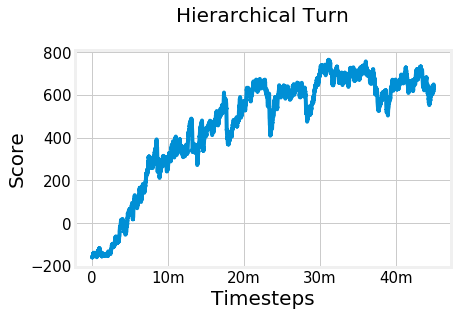

In [41]:
wtimes_n2n_Nav, steps_n2n_Nav, val_n2n_Nav = zip(*n2n_nav.Scalars("episode/episode_reward"))
val_n2n_Nav_smooth = smooth(val_n2n_Nav,0.99)

plt.plot(steps_n2n_Nav,val_n2n_Nav_smooth)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e7,2e7,3e7,4e7],['0','10m','20m','30m','40m'])
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

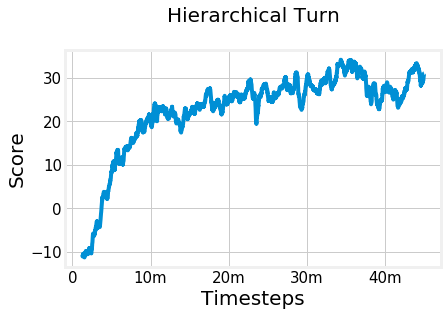

In [38]:
wtimes_n2n_Nav, steps_n2n_Nav, val_n2n_Nav = zip(*n2n_nav.Scalars("input_info/discounted_rewards"))
val_n2n_Nav_smooth = smooth(val_n2n_Nav,0.99)

plt.plot(steps_n2n_Nav[300:],val_n2n_Nav_smooth[300:])
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e7,2e7,3e7,4e7],['0','10m','20m','30m','40m'])
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

In [42]:
print("hours to reach max",(wtimes_n2n_Nav[val_n2n_Nav.index(max(val_n2n_Nav))]-wtimes_n2n_Nav[0])/3600)
print("steps to reach max",steps_n2n_Nav[val_n2n_Nav.index(max(val_n2n_Nav))])

hours to reach max 129.00743128816288
steps to reach max 42970729


### H

In [44]:
h_nav = EventAccumulator('../experiments/233_Nav_from_zero/logs/PPO2_1/')
h_nav.Reload()

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


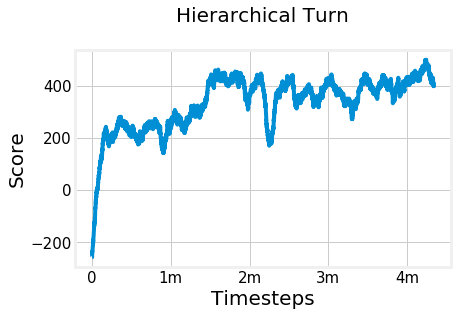

In [50]:
wtimes_h_Nav, steps_h_Nav, val_h_Nav = zip(*h_nav.Scalars("episode/episode_reward"))
val_h_Nav_smooth = smooth(val_h_Nav,0.99)

plt.plot(steps_h_Nav,val_h_Nav_smooth)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Hierarchical Turn\n",fontsize=20)
plt.xticks([0,1e6,2e6,3e6,4e6],['0','1m','2m','3m','4m'])
plt.savefig("plots/h-turn.pdf",bbox_inches="tight", pad_inches=0)

In [51]:
print("hours to reach max",(wtimes_h_Nav[val_h_Nav.index(max(val_h_Nav))]-wtimes_h_Nav[0])/3600)
print("steps to reach max",steps_h_Nav[val_h_Nav.index(max(val_h_Nav))])

hours to reach max 22.705698146621387
steps to reach max 3104484


In [52]:
# NWO    exp148 2053056.pkl
# NWOO   exp199 5176512.pkl
# R      exp96  final.pkl
# X      exp160 784992.pkl
# KL     -
# TC     -
# Turn   exp147 1347216.pkl
# TLeft  exp111 12601008.pkl
# TRight exp112 12601008.pkl
# CLane  exp135 3500928.pkl
# CL     exp127 final.pkl
# CR     exp115 2402304.pkl

# Turn old histogram of actions

In [ ]:
reader = EventFileLoader("../experiments/98_Recovery_dummy/logs/extra/events.out.tfevents.1561361727.29530bff75af")
events = [event for event in list(reader.Load()) if len(event.summary.ListFields()) > 0]

In [ ]:
actions = [[e.wall_time,*e.summary.value[0].histo.bucket] for e in events if 'actions' in e.summary.value[0].tag]
actions_id = [e.step for e in events if 'actions' in e.summary.value[0].tag]

In [ ]:
actions_df = pd.DataFrame(actions,index=actions_id,columns=['walltime',*events[0].summary.value[0].histo.bucket_limit])


In [ ]:
actions_df.loc[:,actions_df.columns[1:]].groupby(by=int, axis='columns').sum().sum().plot("bar")
plt.xticks([0,1],["Direct","Delayed"])
plt.title("History of actions taken by Recovery v1\n",fontsize=20)
plt.savefig("plots/actions_recovery_old.pdf",bbox_inches="tight", pad_inches=0)